<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** CNN LSTM applied to univariate timeseries



# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import rcParams
from matplotlib import pyplot

# Why considering CNN LSTMs for timeseries?
<hr style="border:2px solid black"> </hr>


- The LSTM has an **internal memory** whcih allows to accumulate internal state as it reads across the steps of a given input sequence.

- When operating on one-dimensional data, the CNN reads across a sequence of lag observations and learns to extract  **automatically** features that are relevant for making a prediction. It does it withouth the need of neither scaling nor differecing.

- **So why not combining them all?** Firs use a CNN then use an LSTM model. CNN model is applied to sub-sequences of input data, the results of which together form a time series of extracted features that can be interpreted by an LSTM model.



# Another option is CNN with RNN
<hr style = "border:2px solid black" ></hr>


- RNNs and CNNs are something that you might expect, but let’s consider more interesting models. Local patterns are good, but what if we still imply temporal dependence of these patterns (but RNNs over raw signal is not the best option)? 

- We just should remember, that convolutional nets are **good in dimension reduction** using different pooling techniques and over these reduced representations we already can run recurrent neural nets and their “physical meaning” will be “checking dependency between local patterns over time”, which definitely has the sense for some applications.



# Import the dataset
<hr style="border:2px solid black"> </hr>


- The *monthly car sales* dataset summarizes the monthly car sales in Quebec, Canada between 1960 and 1968.
- The dataset is monthly and has nine years, or 108 observations. 
- The dataset has an **obvious** trend and seasonal component. The period of the seasonal component could be six months or 12 months.
- You generally have the option to remove the seasonal component and this is done most of the time. We said we have the option. **This means that there is no theoretical reason why you MUST**. In this tutorial, it is shown how to create a test harness and accuracy is secondary.



In [2]:
series = read_csv('../../DATASETS/monthly-car-sales.csv',
                  header=0, index_col=0)
data = series.values

In [3]:
print(series.shape)

(108, 1)


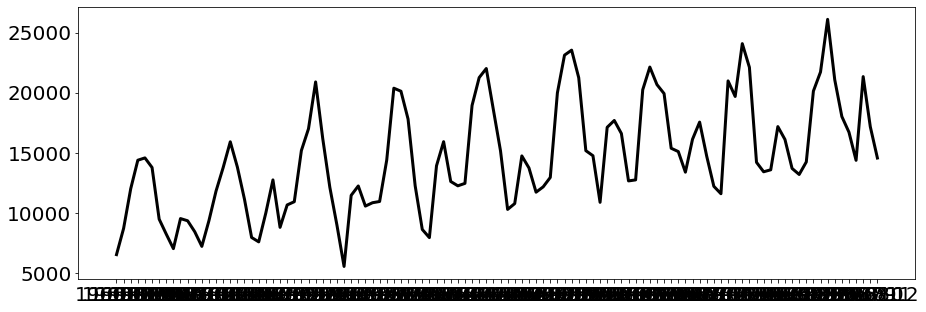

In [4]:
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20
pyplot.plot(series, lw = 3, c= "k")
pyplot.show()

# Develop a test harness
<hr style="border:2px solid black"> </hr>


- A test harness is nothing more that a series of standardised actions you perform to evaluate a model.
- In this case, we have 5 steps:
    - Train-Test Split
    - Series as Supervised Learning
    - Walk-Forward Validation
    - Repeat Evaluation
    - Summarize Performance



## Train-Test split

In [5]:
def train_test_split(data, n_test):
    """Split data
    Split a univariate dataset into train/test sets
    """
    return data[:-n_test], data[-n_test:]

## Series-to-supervised transformation


- Transform list into supervised learning format. This means that each sample must have both an input component and an output component.
- The input component will be some number of prior observations, such as three years or 36 time steps.
- The output component will be the total sales in the next month because we are interested in developing a model to make one-step forecasts.  



In [6]:
def series_to_supervised(data, n_in=1, n_out=1):
    """Series to supervised problem
    """

    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

## Walk-forward validation


- Walk Forward Validation:  it is called like this because this methodology involves moving along the time series one-time step at a time. Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast. You can see that many more models are created. 
- This has the benefit again of providing a much more robust estimation of how the chosen modelling method and parameters will perform in practice.  This improved estimate comes at the computational cost of creating so many models. This is not expensive if the modelling method is simple or dataset is small, but could be an issue at scale.
- Walk-forward validation is the **gold standard** of model evaluation. It is the k-fold cross-validation for time series. Essentially a model may be updated each time step new data is received.



In [7]:
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

## Repeat evaluation


- Neural network models are stochastic and the results is that if everything stay the same but the model is trained multiple times the performance will be different.
- This is a benefit, allowing the model to be adaptive and find high performing configurations to complex problems.
- To address this wie'll evaluate the model several times.



In [8]:
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config)
              for _ in range(n_repeats)]
    return scores

## Compute the loss

In [9]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

## Differencing


- MLPs and CNNs  **do not read** the sequence data one-step at a time.
- LSTMs  read the sequence one step at a time.

- As a consequence of this LSTMs perform better if the data is **stationary**. To do this we use differenceing.

- In the case of the car sales dataset, we can make the data stationery by performing a seasonal adjustment, that is subtracting the value from one year ago from each observation.

- This can be performed systematically for the entire training dataset. It also means that the first year of observations must be discarded as we have no prior year of data to difference them with.



In [10]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

## Modeling & Fitting


- The model requires that each input sequence, e.g. 36 months, is divided into multiple subsequences, each read by the CNN model, e.g. 3 subsequence of 12 time steps. It may make sense to divide the sub-sequences by years, but this is just a hypothesis, and other splits could be used, such as six subsequences of six time steps.

- Therefore, this splitting is parameterized with the `n_seq` and `n_steps` for the number of subsequences and number of steps per subsequence parameters.

- The number of lag observations per sample is simply (n_seq * n_steps).

- This is a 4-dimensional input array now with the dimensions: `[samples, subsequences, timesteps, features]`

- The same CNN model must be applied to each input subsequence. We can achieve this by wrapping the entire CNN model in a `TimeDistributed` layer wrapper.

- The output of one application of the CNN submodel will be a vector. The output of the submodel to each input subsequence will be a time series of interpretations that can be interpreted by an LSTM model. This can be followed by a fully connected layer to interpret the outcomes of the LSTM and finally an output layer for making one-step predictions.



In [11]:
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
              activation='relu', input_shape=(None, n_steps, 1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters,
              kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

## Inference/prediction


- A single input must have the three-dimensional structure of samples, timesteps, and features, which in this case we only have 1 sample and 1 feature: `[1, n_input, 1]`.

- If the difference operation was performed, we must add back the value that was subtracted after the model has made a forecast. We must also difference the historical data prior to formulating the single input used to make a prediction.



In [12]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

## Results summary

In [13]:
def summarize_scores(scores):
    """ Summaruse the results.
    
    Thebox plot helps us understand the spread of the results.
    """
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%.3f RMSE (+/- %.3f)' % (scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

# Run the model
<hr style="border:2px solid black"> </hr>


- The LSTM architecture and hyperparameters is described by `config`:
- `config = [n_input, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch]`
- These are:
    - `n_seq`: The number of subsequences within a sample.
    - `n_steps`: The number of time steps within each subsequence.
    - `n_filters`: The number of parallel filters.
    - `n_kernel`: The number of time steps considered in each read of the input sequence.
    - `n_nodes`: The number of LSTM units to use in the hidden layer.
    - `n_epochs`: The number of times to expose the model to the whole training dataset.
    - `n_batch`: The number of samples within an epoch after which the weights are updated.
        


In [14]:
# Data split: 12 months
n_test = 12

# Define config
config = [3, 12, 64, 3, 100, 200, 100]

# Grid search
scores = repeat_evaluate(data, config, n_test)

 > 1776.314
 > 1555.464
 > 2139.841
 > 1548.588
 > 1525.311
 > 1772.227
 > 1430.986
 > 1778.435
 > 1241.108
 > 1666.502
 > 1552.811
 > 1721.526
 > 1407.629
 > 1569.736
 > 1951.271
 > 1689.088
 > 1303.645
 > 1559.265
 > 1619.905
 > 1420.688
 > 1526.905
 > 1634.971
 > 1546.715
 > 1657.732
 > 1685.298
 > 1944.494
 > 1669.248
 > 1809.618
 > 1657.287
 > 1660.092


1634.090 RMSE (+/- 184.729)


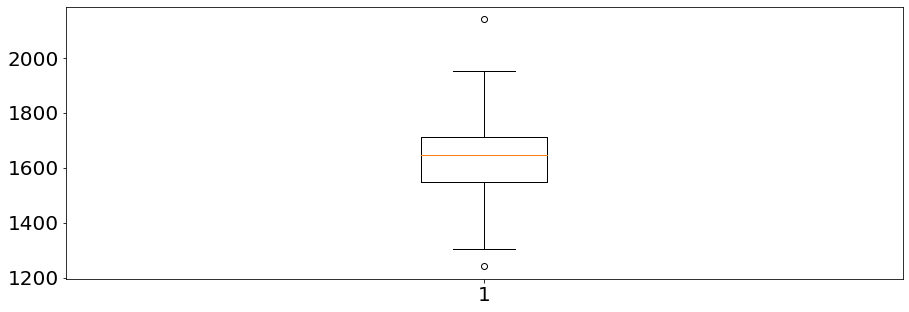

In [15]:
# Summarize scores via box plot
summarize_scores(scores)

# Conclusions
<hr style="border:2px solid black"> </hr>


- We saw how the spread of the results is a bit large.
- CNN-LSTMs like any other ANNs have higher skills and harnessing them, meaning minimising their variance across multiple runs is a **challenge**.
- There are many fixes. The simplest is simply to train multiple final models for use in an ensemble.
- **Walk-Forward**, please note that you can also refit the model at each step. This could further improve model performance.



# References
<hr style="border:2px solid black"> </hr>


- https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv
- https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/    
- [Deep learning: the final frontier for signal processing and time series analysis?](https://alexrachnog.medium.com/deep-learning-the-final-frontier-for-signal-processing-and-time-series-analysis-734307167ad6)

